<a href="https://colab.research.google.com/github/christievanderuit/TM10007_group11/blob/main/TM10007_Group11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sklearn numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=780285f0135421406919526279593820a255c53d92297b8475c554e7a003598e
  Stored in directory: /root/.cache/pip/wheels/d5/b2/a9/590d15767d34955f20a9a033e8db973b79cb5672d95790c0a9
Successfully built sklearn


**Inladen van Packages**

In [ ]:
# General packages
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
from scipy.stats import shapiro

# Classifiers
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn import feature_selection 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score


**Run from the colab enviroment**

In [ ]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git
data = pd.read_csv('/content/tm10007_ml/worcgist/GIST_radiomicFeatures.csv', index_col=0)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

Cloning into 'tm10007_ml'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), 67.99 MiB | 9.12 MiB/s, done.
The number of samples: 246
The number of columns: 494


**Preprocessing of data**

Remove NaN, drop features if only 0

In [ ]:
# Search of NaN 
x_data = data.drop("label", axis='columns')
np.where(np.asanyarray(np.isnan(x_data))) 

# Find all entries that are not a number
x_data = x_data.apply(lambda x: pd.to_numeric(x, errors='coerce'))
nan_b = pd.isna(x_data)
n_nan = nan_b.sum().sum()
if n_nan > 0:
  nan = np.where(nan_b == "True")
else:
  nan = 0

# Drop features with only zeros 
df1 = x_data.mask(x_data != 0).dropna(axis=1)

df2 = x_data.copy()
for col in df1:
    df2 = df2.drop(col, axis=1)


**Split in train and test set**

In [ ]:
#Dataset split in train and test set (x = features, y = label)
y = data['label']
x = df2
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1, stratify=y)


**Exploring Dataset**

Outliers, normal distribution

In [ ]:
# Outliers check with LOF

lof = LocalOutlierFactor()
x_lof = lof.fit(x_train)
outlier_scores = x_lof.negative_outlier_factor_
threshold = np.mean(outlier_scores)
outliers = x_train[outlier_scores < threshold]
outlier_percentage = (len(outliers) / len(x_train)) * 100

print("Number of outliers:", len(outliers))
print("Percentage of outliers:", outlier_percentage)

Number of outliers: 9
Percentage of outliers: 4.591836734693878


In [ ]:
# Test whether the data is normally distributed or not - Shapiro-Wilk test
def test_normality(column):
    stat, p = shapiro(column)
    alpha = 0.05
    if p > alpha:
        return 1
    else:
        return 0

normality_results = x_train.apply(test_normality)

/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


**Preprocessing: scaling**

In [ ]:
# Robust scaling
scaler = preprocessing.RobustScaler()
scaler.fit(x_train)
x_scaled = pd.DataFrame(scaler.transform(x_train))

**Feature extraction / feature selection**

Defining functions for different feature extraction/selection methods

In [ ]:
# PCA

def pca_func(X,n):
  pca = PCA(n_components=n)
  df_pca = pca.fit_transform(X)
  return df_pca

In [ ]:
# SelectKBest
def kbest_func(X, k):
    # Define the feature selector
    selector = SelectKBest(f_classif, k=k)

    # Fit the selector to the training data and transform the data
    x_train_kbest = selector.fit_transform(X, y_train)
    return x_train_kbest

In [ ]:
def selector_function(X,k,y_train):
    
    # Define the feature selector
    selector = SelectKBest(f_classif, k=k)

    # Fit the selector to your training data
    selector.fit(X, y_train)
    
    # Transform your training data to contain only selected feature
    X_train_selected = selector.transform(X)

    return selector


In [ ]:
# RFE
def rfe_func(X,k): 
    # Create a LabelEncoder object 
    le = LabelEncoder()

    # Fit the LabelEncoder object on the target variable
    y_train_encoded = le.fit_transform(y_train)

    # Create a linear regression object
    lr = LinearRegression()

    # Create an RFE object and fit it on the training data
    rfe = RFE(estimator=lr, n_features_to_select=k)
    x_train_rfe = rfe.fit_transform(X, y_train_encoded)
    return x_train_rfe

In [ ]:
# LASSO

def lasso_func(X,k):   
    # Create a LabelEncoder object
    le = LabelEncoder()

    # Fit the LabelEncoder object on the target variable
    y_train_encoded = le.fit_transform(y_train)

    # Lasso regression
    lasso = Lasso(alpha=k)
    
    # Create a SelectFromModel object and fit it on the training data
    selector = SelectFromModel(estimator=lasso)
    selector.fit(X, y_train_encoded)

    # Use the selector object to transform the data
    x_train_lasso = selector.transform(X)
    return x_train_lasso

Making y_train binary

In [ ]:
y_gist = pd.Series([1 if label == "GIST" else 0 for label in y_train], index=y_train.index)  

Choosing a k for kNN to use this as a classifier to select the right feature extraction / selection method for this dataset

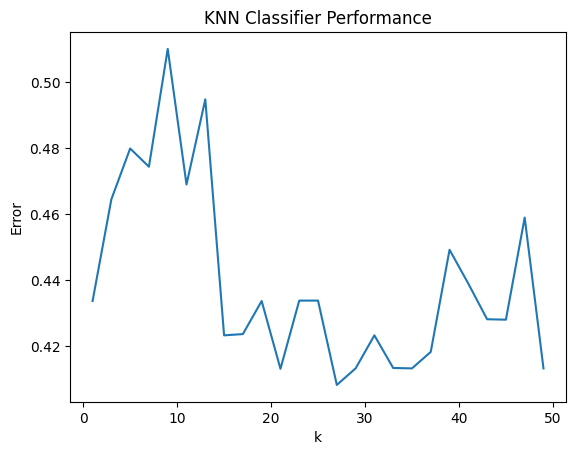

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]


In [ ]:
# Pick k for KNN without feature extraction/selection

# Define a list of k values to test
k_values = list(range(1, 50, 2))

# Train a KNN classifier for each k value and record the test set accuracy
errors = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_scaled, y_gist, cv=5)
    errors.append(1-scores.mean())

# Create a line plot of k vs. test set accuracy
plt.plot(k_values, errors)
plt.xlabel('k')
plt.ylabel('Error')
plt.title('KNN Classifier Performance')
plt.show()
print(k_values)

Testing which feature selection method works best using KNN. Hyperparameters: CV = 5, n_neighbours = 15, n/k = [5 10 20 50 100].

**Feature extraction method testing 1: PCA**

In [ ]:
# KNN  - PCA
n = 100
x_pca = pca_func(x_scaled,n)

# Assume X_train, y_train are numpy arrays or pandas dataframes
# Create a k-NN classifier object with k=5
knn = KNeighborsClassifier(n_neighbors=15)

# Use 5-fold cross-validation to evaluate the performance of the k-NN classifier on the training set
scores = cross_val_score(knn, x_pca, y_gist, cv=5)

# Print the cross-validation scores and their mean
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(scores.mean()*100, scores.std()*100))


Accuracy: 56.13% (+/- 3.29%)


**Feature selection method testing 2: SelectKBest**

In [ ]:
# KNN  - selectKBest

k = 50
x_kbest = kbest_func(x_scaled,k)

# Assume X_train, y_train are numpy arrays or pandas dataframes
# Create a k-NN classifier object with k=5
knn = KNeighborsClassifier(n_neighbors=15)

# Use 5-fold cross-validation to evaluate the performance of the k-NN classifier on the training set
knn_select_scores = cross_val_score(knn, x_kbest, y_gist, cv=5)

# Print the cross-validation scores and their mean
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(knn_select_scores.mean()*100, knn_select_scores.std()*100))

Accuracy: 60.22% (+/- 4.31%)


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


**Feature selection method testing 3: RFE**

In [ ]:
# KNN  - RFE

k = 100
x_rfe = rfe_func(x_scaled,k)

# Assume X_train, y_train are numpy arrays or pandas dataframes
# Create a k-NN classifier object with k=5
knn = KNeighborsClassifier(n_neighbors=15)

# Use 5-fold cross-validation to evaluate the performance of the k-NN classifier on the training set
scores = cross_val_score(knn, x_rfe, y_gist, cv=5)

# Print the cross-validation scores and their mean
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(scores.mean()*100, scores.std()*100))

Accuracy: 59.72% (+/- 4.44%)


**Feature selection method testing 4: LASSO**

In [ ]:
# KNN - lasso

k = 10
x_lasso = lasso_func(x_scaled, k)

# Assume X_train, y_train are numpy arrays or pandas dataframes
# Create a k-NN classifier object with k=5
knn = KNeighborsClassifier(n_neighbors=15)

# Use 5-fold cross-validation to evaluate the performance of the k-NN classifier on the training set
scores = cross_val_score(knn, x_lasso, y_gist, cv=5)

# Print the cross-validation scores and their mean
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(scores.mean()*100, scores.std()*100))

Accuracy: 53.08% (+/- 4.26%)


Results of the best feature selection/extraction combined with KNN, Non-linear SVM and Random Forrest. Also hyperparameter optimilization.

**SelectKBest as best feature selection thus using this as a method for testing the classifiers**

Method 1: Hyperparametrisering of kNN and showing results 

Best parameters: {'metric': 'euclidean', 'n_neighbors': 77, 'weights': 'uniform'}
Best accuracy: 0.6176923076923078
Best ROC AUC score: 0.7001447368421053


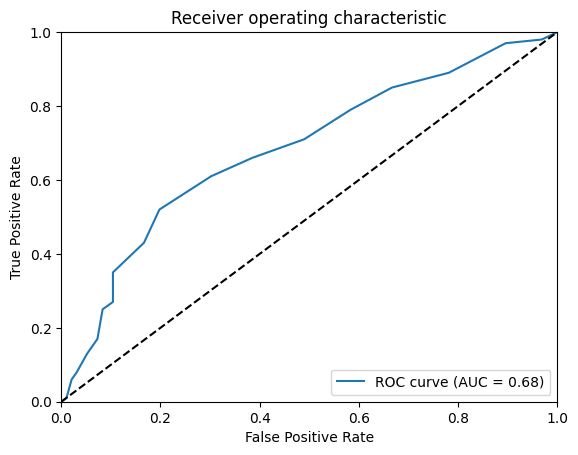

In [ ]:
# Create a k-nearest neighbors classifier object
knn = KNeighborsClassifier()

# Define the parameter grid to search over
param_grid = {
    'n_neighbors': list(range(1, 100, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Define the cross-validation object with a random state of 42
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Perform grid search with cross-validation and a random state of 1

# Perform grid search cross-validation to find the optimal hyperparameters
# Create a GridSearchCV object to search over the parameter grid using accuracy and ROC AUC score
scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='roc_auc')
grid_search.fit(x_kbest, y_gist)

# Print the best hyperparameters and both accuracy and ROC AUC score found by GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
print("Best ROC AUC score:", grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])

# train the model with best hyperparameters
best_model = grid_search.best_estimator_

# generate predicted labels or scores using cross-validation
y_pred = cross_val_predict(best_model, x_kbest, y_gist, cv=5, method='predict')
y_pred_proba = cross_val_predict(best_model, x_kbest, y_gist, cv=5, method='predict_proba')[:, 1]

# calculate false positive rate and true positive rate at different thresholds
fpr, tpr, thresholds = roc_curve(y_gist, y_pred_proba)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Choose weights and metrics. Find k based on error curve 

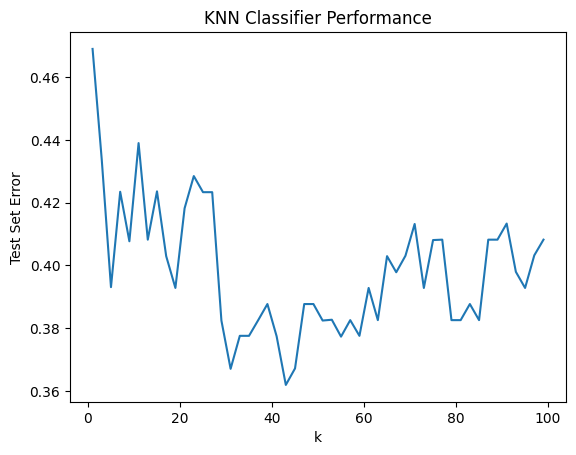

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


In [ ]:
# Pick k for KNN without feature extraction/selection

# Define a list of k values to test
k_values = list(range(1, 100, 2))

# Train a KNN classifier for each k value and record the test set accuracy
errors = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='uniform')
    scores = cross_val_score(knn, x_kbest, y_gist, cv=cv)
    errors.append(1-scores.mean())

# Create a line plot of k vs. test set accuracy
plt.plot(k_values, errors)
plt.xlabel('k')
plt.ylabel('Test Set Error')
plt.title('KNN Classifier Performance')
plt.show()
print(k_values)

Results of kNN classifier with chosen value of kneighbours based on error-plot

Accuracy: 60.69% (+/- 5.88%)
ROC AUC score: 0.6339062500000001


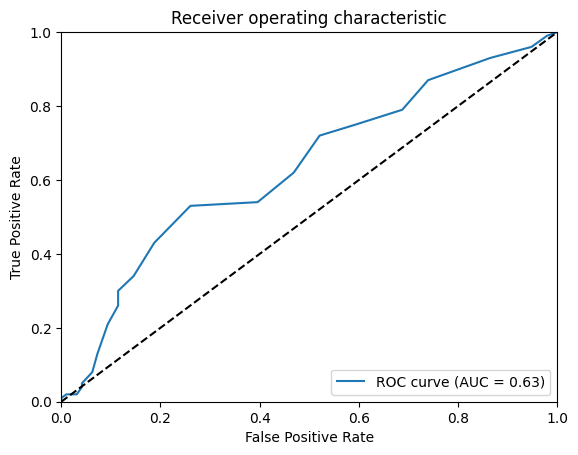

In [ ]:
# Create a k-nearest neighbors classifier object
k = 5 #based on error plot
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='uniform')
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Train the classifier on the training data
knn.fit(x_kbest, y_gist)

# Use 5-fold cross-validation to evaluate the performance of the k-NN classifier on the training set
knn_select_scores = cross_val_score(knn, x_kbest, y_gist, cv=cv)

# Print the cross-validation scores and their mean
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(knn_select_scores.mean()*100, knn_select_scores.std()*100))

y_pred = cross_val_predict(best_model, x_kbest, y_gist, cv=cv, method='predict')
y_pred_proba = cross_val_predict(best_model, x_kbest, y_gist, cv=cv, method='predict_proba')[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_gist, y_pred_proba)
print("ROC AUC score:", roc_auc)

# Get the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_gist, y_pred_proba)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Method 2: Hyperparametrisering of Non-Linear SVM and showing results

Best parameters: {'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid'}
Best accuracy: 0.6383333333333333
Standard deviation of accuracy scores: 0.06113166828943978
Best ROC AUC score: 0.7014736842105262


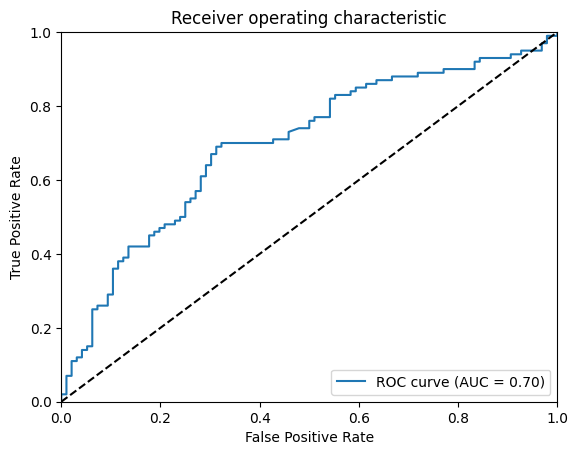

In [ ]:
#Hyperparameter optimalization - Non linear SVM - SelectKBest 

#parameter grid --> gridsearch
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'degree': [2, 3, 4],
    'coef0': [0, 1, 2]
}

# Initialize an instance of the SVC class with initial hyperparameters
svc = SVC(probability=True)

# Perform grid search cross-validation to find the optimal hyperparameters
# Create a GridSearchCV object to search over the parameter grid using accuracy and ROC AUC score
scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
grid_search_svm = GridSearchCV(svc, param_grid, cv=5, scoring=scoring, refit='roc_auc')
grid_search_svm.fit(x_kbest, y_gist)

# Print the best hyperparameters and both accuracy and ROC AUC score found by GridSearchCV
print("Best parameters:", grid_search_svm.best_params_)
print("Best accuracy:", grid_search_svm.cv_results_['mean_test_accuracy'][grid_search_svm.best_index_])
print("Standard deviation of accuracy scores:", grid_search_svm.cv_results_['std_test_accuracy'][grid_search_svm.best_index_])
print("Best ROC AUC score:", grid_search_svm.cv_results_['mean_test_roc_auc'][grid_search_svm.best_index_])

# train the model with best hyperparameters
best_model_svm = grid_search_svm.best_estimator_

# generate predicted labels or scores using cross-validation
y_pred_svm = cross_val_predict(best_model_svm, x_kbest, y_gist, cv=5, method='predict')
y_pred_proba_svm = cross_val_predict(best_model_svm, x_kbest, y_gist, cv=5, method='predict_proba')[:, 1]

# calculate false positive rate and true positive rate at different thresholds
fpr, tpr, thresholds = roc_curve(y_gist, y_pred_proba_svm)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Method 3: Hyperparametrisering of Random Forest and showing results 

Best parameters: {'n_estimators': 21}
Best accuracy: 0.6073076923076923
Standard deviation of accuracy scores: 0.06878727845934542
Best ROC AUC score: 0.643407894736842


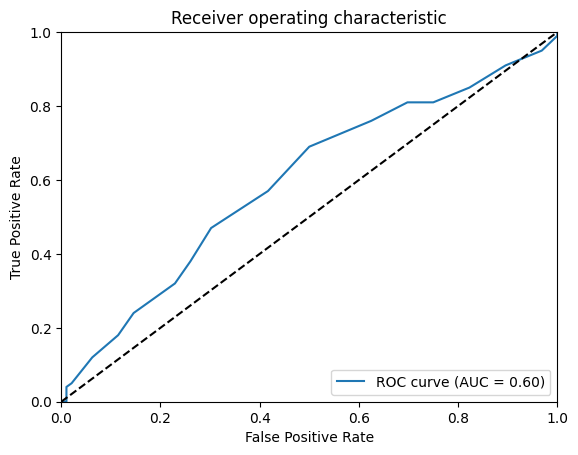

In [ ]:
# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': list(range(1, 200, 20)),
}

# Random forest
rf = RandomForestClassifier()

# Create a GridSearchCV object to search over the parameter grid using accuracy and ROC AUC score
scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring=scoring, refit='roc_auc')

# Fit the GridSearchCV object to the data
grid_search.fit(x_kbest, y_gist)

# Print the best hyperparameters and both accuracy and ROC AUC score found by GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
print("Standard deviation of accuracy scores:", grid_search.cv_results_['std_test_accuracy'][grid_search.best_index_])
print("Best ROC AUC score:", grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])

# train the model with best hyperparameters
best_model = grid_search.best_estimator_

# generate predicted labels or scores using cross-validation
y_pred = cross_val_predict(best_model, x_kbest, y_gist, cv=5, method='predict')
y_pred_proba = cross_val_predict(best_model, x_kbest, y_gist, cv=5, method='predict_proba')[:, 1]

# calculate false positive rate and true positive rate at different thresholds
fpr, tpr, thresholds = roc_curve(y_gist, y_pred_proba)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**Results of chosen classifier on testset**

/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Accuracy: 0.56
ROC AUC: 0.6864


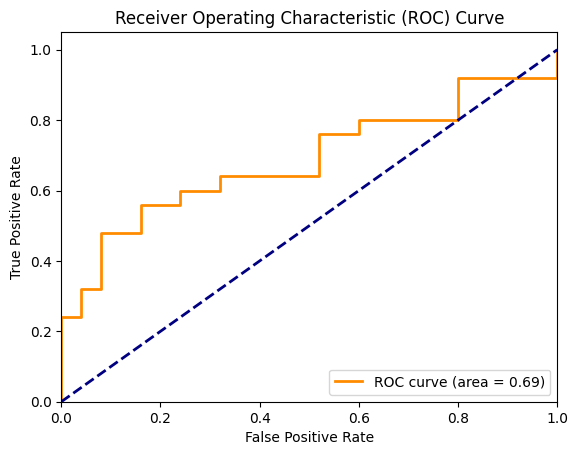

In [ ]:
#scaling 
x_scaled_test = pd.DataFrame(scaler.transform(x_test))

#transform test data using from training data
selector_test = selector_function(x_scaled, 50, y_train)
x_test_selected = selector_test.transform(x_scaled_test)

#using the best grid svm on test data 
y_pred_test = best_model_svm.predict(x_test_selected)

# Evaluate the performance of the model on your test data

y_gist_test = pd.Series([1 if label == "GIST" else 0 for label in y_test], index=y_test.index)  

accuracy_test = accuracy_score(y_gist_test, y_pred_test)
roc_auc_test = roc_auc_score(y_gist_test, best_model_svm.predict_proba(x_test_selected)[:,1])

print("Accuracy:", accuracy_test)
print("ROC AUC:", roc_auc_test)

# Compute ROC curve and ROC area for the test set
fpr, tpr, thresholds = roc_curve(y_gist_test, best_model_svm.predict_proba(x_test_selected)[:,1])
roc_auc = roc_auc_score(y_gist_test, best_model_svm.predict_proba(x_test_selected)[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


**Using outer Cross Validation**

In [ ]:
from numpy import mean
from numpy import std 

y = data['label']
X = df2
X = X.reset_index(drop=True)

# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X.loc[train_ix, :], X.loc[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    
    #scaling of train 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    x_scaled = pd.DataFrame(scaler.transform(X_train))      
    #scaling of xtest
    x_scaled_test = pd.DataFrame(scaler.transform(X_test))

    #transform test data using from training data
    selector_test = selector_function(x_scaled, 50, y_train)
    x_test_selected = selector_test.transform(x_scaled_test)
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1) #cv inner niet gebruiken want niet verder updaten van je model 

    #using the best grid svm on test data 
    y_pred_test = best_model_svm.predict(x_test_selected)

    # Evaluate the performance of the model on your test data

    y_gist_test = pd.Series([1 if label == "GIST" else 0 for label in y_test], index=y_test.index)  

    #accuracy_test = accuracy_score(y_gist_test, y_pred_test)
    roc_auc = roc_auc_score(y_gist_test, best_model_svm.predict_proba(x_test_selected)[:,1])

    # store the result
    outer_results.append(roc_auc)
    
    # report progress
    print('>acc=%.3f' % (roc_auc))

# summarize the estimated performance of the model
print('roc auc: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))




/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


>acc=0.391
>acc=0.667


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


>acc=0.410
>acc=0.468


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 76  77  83  84  85  90  96  97 103 109 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


>acc=0.519
>acc=0.596


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


>acc=0.687
>acc=0.637
>acc=0.611
>acc=0.481
Accuracy: 0.547 (0.102)


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

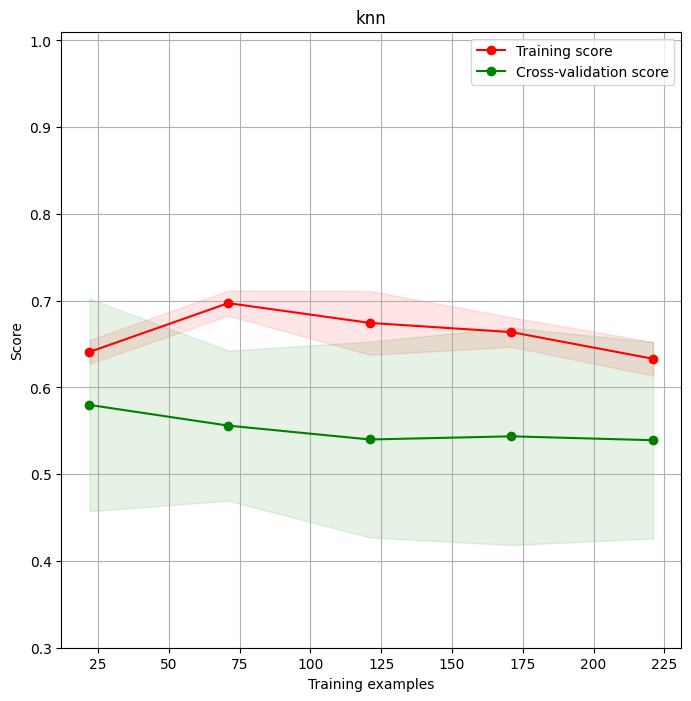

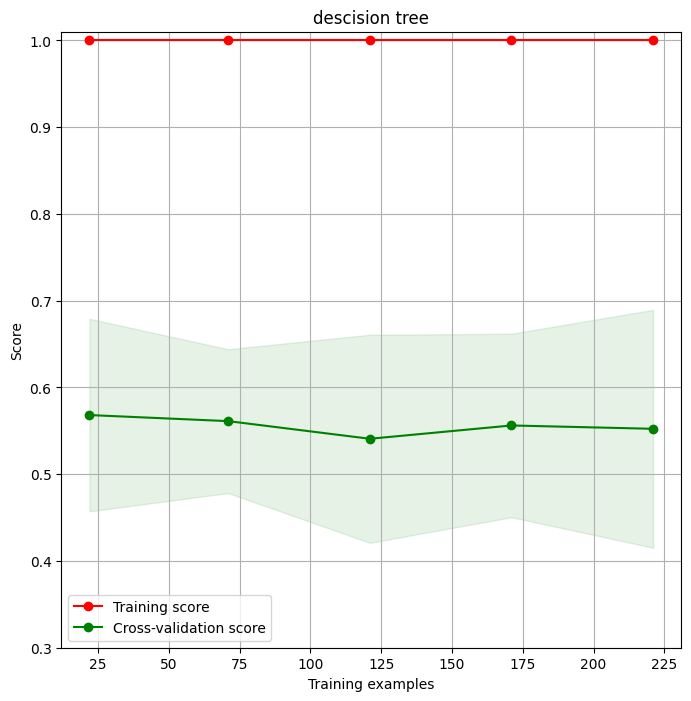

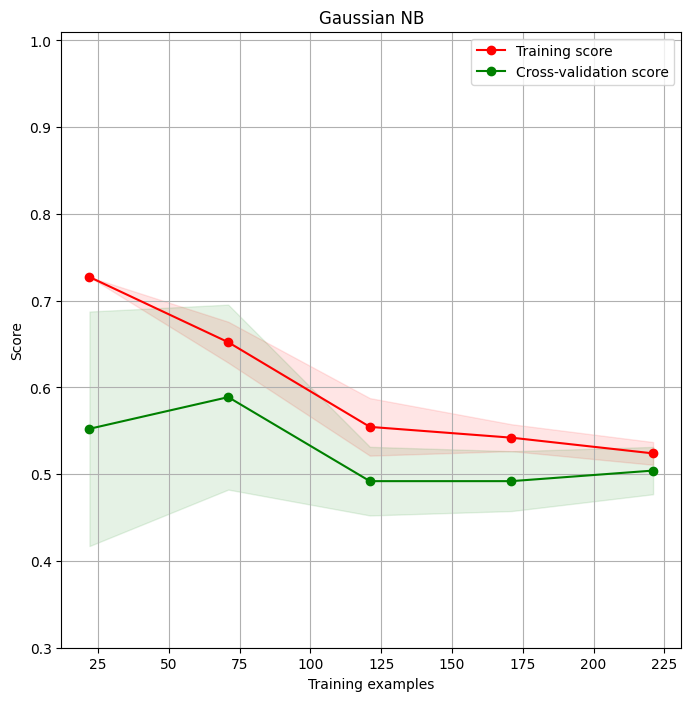

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

#knn gebruiken als een classifier 
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1) 
clf = knn
title = "knn"
plot_learning_curve(clf, title, x, y, ax, ylim=(0.3, 1.01), cv=10)


from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1) 
title = "descision tree"
plot_learning_curve(clf, title, x, y, ax, ylim=(0.3, 1.01), cv=10)


from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1) 
title = "Gaussian NB"
plot_learning_curve(clf, title, x, y, ax, ylim=(0.3, 1.01), cv=10)
